## Import library

In [1]:
import sys

MAIN_PATH = "/home/trduong/Data/interpretable_machine_learning/Source Code/my_work"


sys.path.insert(
    1,
    MAIN_PATH + '/lib'
)

sys.path.insert(
    1,
    MAIN_PATH + '/config'
)

import numpy as np
import pandas as pd
import logging
import incremental_ps_score_estimator as ipse
import math
import timeit
import utils
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import KFold
import experiment_config as cf

import dowhy.datasets
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt

from econml.drlearner import ForestDRLearner, LinearDRLearner
from econml.metalearners import SLearner, XLearner, TLearner
from econml.ortho_forest import CausalTree, ContinuousTreatmentOrthoForest, DiscreteTreatmentOrthoForest
from econml.dml import ForestDMLCateEstimator, LinearDMLCateEstimator, SparseLinearDMLCateEstimator
from econml.inference import BootstrapInference
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedLassoCV

### Import sklearn
from scipy.stats import sem
import scipy.stats as st
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LassoCV, ElasticNetCV
from bartpy.sklearnmodel import SklearnModel


from zepid.causal.doublyrobust import TMLE
from cforest.forest import CausalForest


/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load data 

In [2]:
result_dic = {
    'ortho_train':0,
    'ortho_test':0,
    'linear_dr_train':0,
    'linear_dr_test':0,
    'forest_dr_train':0,
    'forest_dr_test':0,
    'incremental_train':0,
    'incremental_test':0,
    'causal_forest_train':0,
    'causal_forest_test':0,
    'tmle_train':0,
    'tmle_test':0,
    'knn_train':0,
    'knn_test':0,
    'ps_train':0,
    'ps_test':0,
    'lr_train':0,
    'lr_test':0,
    'bart_train':0,
    'bart_test':0,
}

In [3]:
# Import the sample AB data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/RecommendationAB/ab_sample.csv"   
ab_data = pd.read_csv(file_url)

In [4]:
ab_data.head()

,days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows,easier_signup,became_member,days_visited_post
0,1,9,7,25,6,3,1,0.01,0,1,0,0,1
1,10,25,27,10,27,27,0,2.26,0,0,0,0,15
2,18,14,8,4,5,2,1,0.03,0,1,0,0,17
3,17,0,23,2,3,1,1,418.77,0,1,0,0,6
4,24,9,22,2,3,18,1,1.54,0,0,0,0,12


In [5]:
ab_data.shape

In [6]:
ab_data.became_member.value_counts()

0    64780
1    35220
Name: became_member, dtype: int64

In [7]:
ab_data.columns

Index(['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
       'easier_signup', 'became_member', 'days_visited_post'],
      dtype='object')

In [8]:
# Define estimator inputs
Z = ab_data['easier_signup'] # nudge, or instrument
T = ab_data['became_member'] # intervention, or treatment
Y = ab_data['days_visited_post'] # outcome of interest
X_data = ab_data.drop(columns=['easier_signup', 'became_member', 'days_visited_post']) # features

col = ['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
       'easier_signup', 'became_member', 'days_visited_post']

cov = ['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
       'easier_signup']

features = ['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
            'became_member']

treatment = 'became_member' # intervention, or treatment
outcome = 'days_visited_post' # outcome of interest




In [9]:
# Define underlying treatment effect function 
TE_fn = lambda X: (0.2 + 0.3 * X['days_visited_free_pre'] - 0.2 * X['days_visited_hs_pre'] + X['os_type_osx']).values
true_TE = TE_fn(ab_data[cov])

In [10]:
true_effect = np.mean(true_TE)

In [11]:
ab_data[features]

,days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows,became_member
0,1,9,7,25,6,3,1,0.01,0,1,0
1,10,25,27,10,27,27,0,2.26,0,0,0
2,18,14,8,4,5,2,1,0.03,0,1,0
3,17,0,23,2,3,1,1,418.77,0,1,0
4,24,9,22,2,3,18,1,1.54,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,27,27,8,4,25,20,1,0.02,1,0,1
99996,22,21,15,27,24,18,0,6.98,1,0,1
99997,13,5,5,25,28,24,1,0.01,0,1,0
99998,21,13,5,24,14,2,0,0.07,0,0,1


In [12]:
ab_data.became_member.value_counts()

0    64780
1    35220
Name: became_member, dtype: int64

In [13]:
features

['days_visited_exp_pre',
 'days_visited_free_pre',
 'days_visited_fs_pre',
 'days_visited_hs_pre',
 'days_visited_rs_pre',
 'days_visited_vrs_pre',
 'locale_en_US',
 'revenue_pre',
 'os_type_osx',
 'os_type_windows',
 'became_member']

In [14]:
train, test = train_test_split(ab_data, test_size=0.3, random_state = 1)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

## Fit treatment
model_t = LogisticRegression()
model_t.fit(train[cov], train[treatment])

train['p1'] = model_t.predict_proba(train[cov])[:,1]
train['p0'] = 1 - train['p1']

train["prediction"] = np.where(train["p1"] >= 0.5, 1, 0)
acc = accuracy_score(train["prediction"], train[treatment])
print("Accuracy score of train data {}".format(acc))

## Fit outcome
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 1000)
model_y.fit(train[features], train[outcome])


/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy score of train data 0.8393285714285714


GradientBoostingRegressor(n_estimators=1000, random_state=0)

In [15]:
delta = 3
influence_train = ipse.influence_function(train, treatment, cov, outcome, features, delta, model_y, model_t)
influence_test = ipse.influence_function(test, treatment, cov, outcome, features, delta, model_y, model_t)
means_incre_train, stds_incre_train = np.mean(influence_train, axis=0), sem(influence_train, axis=0)
means_incre_test, stds_incre_test = np.mean(influence_test, axis=0), sem(influence_test, axis=0)

true_effect_test = np.mean(TE_fn(test[cov]))
true_effect_train = np.mean(TE_fn(train[cov]))

print("Training")
print("Estimation effect {:.2f}".format(means_incre_train))
print("True effect {:.2f}".format(true_effect_train))

print("Testing")
print("Estimation effect {:.2f}".format(means_incre_test))
print("True effect {:.2f}".format(true_effect_test))


Training
Estimation effect 2.89
True effect 1.94
Testing
Estimation effect 3.25
True effect 1.94


## Optimzation with individual delta and true_effect

In [16]:
def incre_ps(delta, data):
    q1 = (delta * data['p1']) / (delta * data['p1'] + data['p0'])
    q1 = tf.math.abs(q1)
    a0 = (1-q1)*data['w0']*(data['cf0'] - data[outcome])
    a1 = q1*data['w1']*(data['cf1'] - data[outcome])    
    influence = a1 - a0
    return tf.reduce_mean(influence), influence

def optimization(train, test, true_effect):
    threhold = tf.constant([0.01])
    delta = tf.Variable(20, dtype = tf.float32)
    
    delta_seq = []
    losses = []
    losses_test = []
    effects_train = []
    effects_test = []
    influences_train = []
    influences_test = []
    for i in tqdm(range(3000)):
        with tf.GradientTape() as tape:
            mu_influence_train, influence_train = incre_ps(delta, train)
            mu_influence_test, influence_test = incre_ps(delta, test)
            loss = tf.math.abs(true_effect - mu_influence_train)
            loss_test = tf.math.abs(true_effect - mu_influence_test)
            d_delta = tape.gradient(loss, delta)
            opt = tf.keras.optimizers.Adam(learning_rate=0.01)
            opt.apply_gradients(zip([d_delta], [delta]))
            ## early stopping 
            if tf.math.less(loss, threhold):
                print("The performance reach MAE: 0.001. Cancelling the training at step {}".format(i))
                break
            delta_seq.append(delta.numpy())
            losses.append(loss.numpy())
            losses_test.append(loss_test.numpy())
            effects_train.append(mu_influence_train.numpy())
            effects_test.append(mu_influence_test.numpy())
            influences_train.append(influence_train.numpy())
            influences_test.append(influence_test.numpy())
        if i % 1000 == 0:
            print("Epoch {}. Loss {:.4f}".format(i, loss))
            print(influence_test.shape)
    print("Loss {:.3f}".format(loss))
    return delta, delta_seq, losses, losses_test, influences_train, influences_test

In [17]:
delta, delta_seq, losses, losses_test, influences_train, influences_test = optimization(train, test, true_effect)

  0%|          | 8/3000 [00:00<00:38, 77.00it/s]

Epoch 0. Loss 1.3595
(30000,)


 34%|███▍      | 1013/3000 [00:12<00:24, 81.08it/s]

Epoch 1000. Loss 1.1810
(30000,)


 67%|██████▋   | 2016/3000 [00:24<00:13, 75.14it/s]

Epoch 2000. Loss 0.0180
(30000,)


100%|██████████| 3000/3000 [00:50<00:00, 58.99it/s]

Loss 0.052


In [18]:
delta_seq[-1]

0.002569844

In [19]:
lowers_train, uppers_train = [], []
lowers_test, uppers_test = [], []
means_train, means_test = [], []

for i in tqdm(range(len(delta_seq))):

    mean_train, mean_test = np.mean(influences_train[i]), np.mean(influences_test[i])
    stds_incre_train, stds_incre_test = sem(influences_train[i], axis=0), sem(influences_test[i], axis=0)
    
    lower_train, upper_train = st.t.interval(0.90, 
                                         len(influences_train[i])-1, 
                                         loc=mean_train, 
                                         scale=stds_incre_train)
    lower_test, upper_test = st.t.interval(0.90, 
                                             len(influences_test[i])-1, 
                                             loc=mean_test, 
                                             scale=stds_incre_test)
    

    lowers_train.append(lower_train)
    uppers_train.append(upper_train)
    lowers_test.append(lower_test)
    uppers_test.append(upper_test)
    means_train.append(mean_train)
    means_test.append(mean_test)

100%|██████████| 3000/3000 [00:09<00:00, 319.81it/s]


In [20]:
optimal_mae_train = utils.abs_ate(true_effect_train, mean_train)
optimal_mae_test = utils.abs_ate(true_effect_test, mean_test)

origin_mae_train = utils.abs_ate(true_effect_train, means_incre_train)
origin_mae_test = utils.abs_ate(true_effect_test, means_incre_test)


In [21]:
result_dic['incremental_train'] = optimal_mae_train
result_dic['incremental_test'] = optimal_mae_test

## Conclusion

In [22]:
print("Before Optimization")
print("MAE on training {:.3f} and testing {:.3f}".format(origin_mae_train, origin_mae_test))
print("After Optimization")
print("MAE on training {:.3f} and testing {:.3f}".format(optimal_mae_train, optimal_mae_test))


Before Optimization
MAE on training 0.959 and testing 1.308
After Optimization
MAE on training 0.054 and testing 0.360


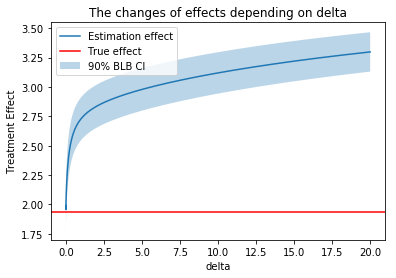

In [23]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(delta_seq, means_train, label='Estimation effect')
plt.axhline(y=true_effect_train, color='r', linestyle='-', label = "True effect")
plt.fill_between(np.array(delta_seq).reshape(-1), lowers_train, uppers_train, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(cf.FIGURE_PATH + '/a_b_testing_train.png')


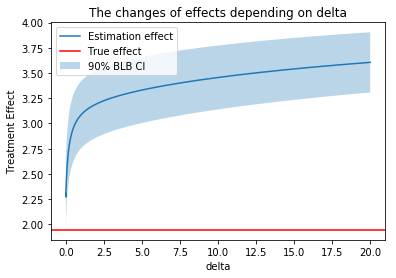

In [24]:
fig = plt.figure()
plt.plot(delta_seq, means_test, label='Estimation effect')
plt.axhline(y=true_effect_test, color='r', linestyle='-', label = "True effect")
plt.fill_between(np.array(delta_seq).reshape(-1), lowers_test, uppers_test, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(cf.FIGURE_PATH + '/a_b_testing_test.png')


## Compare with other methods

### BART

In [25]:
def causal_bart(data, bart_model):
    data_pos = data.copy()
    data_pos[treatment] = 1
    data['treated_cf_outcome'] = bart_model.predict(data_pos[features])

    ## Compute counterfactual outcome with treatment
    data_neg = data.copy()
    data_neg[treatment] = 0
    data['control_cf_outcome'] = bart_model.predict(data_neg[features])
    
    return np.mean(data['treated_cf_outcome'] - data['control_cf_outcome'])

In [26]:
train, test = train_test_split(ab_data, test_size=0.3, random_state = 1)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)


(array([ 8, 16, 14, ..., -1,  8, 19]),
 array([[11., 14.,  5., ...,  0.,  1.,  1.],
        [23., 21.,  5., ...,  0.,  1.,  0.],
        [13., 16.,  7., ...,  0.,  0.,  1.],
        ...,
        [ 7., 13., 21., ...,  1.,  0.,  0.],
        [22., 21.,  2., ...,  1.,  0.,  0.],
        [18., 27., 26., ...,  0.,  0.,  1.]]))

In [31]:
bart_model = SklearnModel(n_trees = 2) # Use default parameters
bart_model.fit(train[features].values, train[outcome].values)

effects_train = causal_bart(train, bart_model)
effects_test = causal_bart(test, bart_model)

mae_bart_train = utils.abs_ate(true_effect_train, effects_train)
mae_bart_test = utils.abs_ate(true_effect_test, effects_test)



NotImplementedError: memoryview: format O not supported

In [ ]:
result_dic['bart_train'] = mae_bart_train
result_dic['bart_test'] = mae_bart_test

### TMLE

In [28]:
expose_m = ' + '.join(cov)
outcome_m = ' + '.join(features)

model_t = LogisticRegression(penalty='l2', random_state=201)
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)

tml = TMLE(train, exposure=treatment, outcome=outcome)
tml.exposure_model(expose_m, bound=[0.01, 0.99], print_results=False, custom_model=model_t)
tml.outcome_model(outcome_m, print_results=False, custom_model = model_y)
tml.fit()

mae_train = utils.abs_ate(true_effect_train, tml.average_treatment_effect)

tml = TMLE(test, exposure=treatment, outcome=outcome)
tml.exposure_model(expose_m, bound=[0.01, 0.99], print_results=False, custom_model=model_t)
tml.outcome_model(outcome_m, print_results=False)
tml.fit()

mae_test = utils.abs_ate(true_effect_test, tml.average_treatment_effect)


result_dic['tmle_train'] = mae_train
result_dic['tmle_test'] = mae_test


/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

### KNN and Linear Regression

In [32]:
model = CausalModel(data=train,
                    treatment=treatment,
                    outcome=outcome,
                    common_causes=cov, proceed_when_unidentifiable=True)
train[treatment] = [bool(x) for x in train[treatment]]
identified_estimand = model.identify_effect()

estimate_we = model.estimate_effect(
        identified_estimand, method_name="backdoor.propensity_score_matching")

estimate_linear = model.estimate_effect(
        identified_estimand, method_name="backdoor.linear_regression")


model = CausalModel(data=test,
                    treatment=treatment,
                    outcome=outcome,
                    common_causes=cov, proceed_when_unidentifiable=True)
test[treatment] = [bool(x) for x in test[treatment]]
identified_estimand = model.identify_effect()

estimate_we_test = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_matching")

estimate_linear_test = model.estimate_effect(
        identified_estimand, method_name="backdoor.linear_regression")

knn_train = utils.abs_ate(true_effect_train, estimate_we.value)
knn_test = utils.abs_ate(true_effect_test, estimate_we_test.value)
lr_train = utils.abs_ate(true_effect_train, estimate_linear.value)
lr_test = utils.abs_ate(true_effect_test, estimate_linear_test.value)


result_dic['knn_train'] = knn_train
result_dic['knn_test'] = knn_test

result_dic['lr_train'] = lr_train
result_dic['lr_test'] = lr_test

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['became_member'] on outcome ['days_visited_post']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['days_visited_vrs_pre', 'revenue_pre', 'days_visited_exp_pre', 'days_visited_fs_pre', 'easier_signup', 'os_type_osx', 'locale_en_US', 'days_visited_rs_pre', 'os_type_windows', 'days_visited_free_pre', 'U', 'days_visited_hs_pre']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: days_visited_post~became_member+days_visited_vrs_pre+revenue_pre+days_vis

                            OLS Regression Results                            
Dep. Variable:      days_visited_post   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     4874.
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:45:23   Log-Likelihood:            -2.2232e+05
No. Observations:               70000   AIC:                         4.447e+05
Df Residuals:                   69987   BIC:                         4.448e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9154      0.102     18.700      0.0

/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: days_visited_post~became_member+days_visited_vrs_pre+revenue_pre+days_visi

                            OLS Regression Results                            
Dep. Variable:      days_visited_post   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     2103.
Date:                Wed, 15 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:45:41   Log-Likelihood:                -95354.
No. Observations:               30000   AIC:                         1.907e+05
Df Residuals:                   29987   BIC:                         1.908e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8846      0.157     11.975      0.0

### Causal Forest

In [36]:
cf = CausalForest(
        num_trees=50,
        split_ratio=0.5,
        min_leaf=5,
        max_depth=20,
        use_transformed_outcomes=True,
        num_workers=4,
        seed_counter=1,
    )

train['term_t'] = train[treatment].apply(lambda x: bool(x))
test['term_t'] = test[treatment].apply(lambda x: bool(x))
    
    
cf = cf.fit(train[features].values, train['term_t'].values, train[outcome].values)

cf_train = np.mean(cf.predict(train[features].values))
cf_test = np.mean(cf.predict(test[features].values))

mae_train = utils.abs_ate(true_effect_train, cf_train)
mae_test = utils.abs_ate(true_effect_test, cf_test)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type array(pyobject, 1d, C)
During: typing of argument at /home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/cforest/tree.py (282)

File "../../../../../../../home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/cforest/tree.py", line 282:
def _find_optimal_split_inner_loop(
    <source elided>
    """
    if len(splitting_indices) == 0:
    ^


In [ ]:
result_dic['causal_forest_train'] = mae_train
result_dic['causal_forest_test'] = mae_test

## Conclusion

In [37]:
for k,v in result_dic.items():
    print(k,v)

ortho_train 0
ortho_test 0
linear_dr_train 0
linear_dr_test 0
forest_dr_train 0
forest_dr_test 0
incremental_train 0.05436899551391616
incremental_test 0.3601332190195723
causal_forest_train 0
causal_forest_test 0
tmle_train 1.065954300913628
tmle_test 1.4575334215539122
knn_train 1.9377614285714289
knn_test 3.154766666666667
ps_train 0
ps_test 0
lr_train 2.562174001166059
lr_test 2.6954712330640147
bart_train 0
bart_test 0
